<a href="https://colab.research.google.com/github/Samarth-991/DeepNeuralNetwork_visualization/blob/master/01_Chest_XRAY_with_CNN_Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# ! unzip /content/chest-xray-pneumonia.zip 

! rm -rf /content/chest_xray/__MACOSX
! rm -rf /content/chest_xray/chest_xray

In [2]:
import os
import glob 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf 
import gc
print (tf.__version__)
import sklearn
np.random.seed(47)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.3.0


In [3]:
Data_path = '/content/chest_xray'
Train_path = os.path.join(Data_path,'train')
Test_path = os.path.join(Data_path,'test')
Val_path = os.path.join(Data_path,'val')

train_imgs = []
train_label = []

test_imgs = [] 
test_label = []

val_imgs = []
val_label =[]

for raw,subdirs,files in os.walk('/content/chest_xray/train/'):
  for name in files:
    train_imgs.append(os.path.join(raw, name))
    train_label.append(os.path.split(raw)[1])

for raw,subdirs,files in os.walk('/content/chest_xray/test/'):
  for name in files:
    test_imgs.append(os.path.join(raw, name))
    test_label.append(os.path.split(raw)[1])


for raw,subdirs,files in os.walk('/content/chest_xray/val/'):
  for name in files:
    val_imgs.append(os.path.join(raw, name))
    val_label.append(os.path.split(raw)[1])

train_df = pd.DataFrame({'images':train_imgs,'labels':train_label})
test_df = pd.DataFrame({'images':test_imgs,'labels':test_label})
val_df = pd.DataFrame({'images':val_imgs,'labels':val_label})

print("NUmber of train images: ", len(train_df))
print("NUmber of test images: ", len(test_df))
print("NUmber of validation images: ", len(val_df))

gc.collect()

NUmber of train images:  5216
NUmber of test images:  624
NUmber of validation images:  16


22

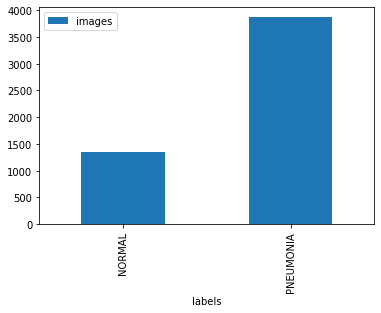

In [4]:
from sklearn.utils import shuffle
train_df = shuffle(train_df,random_state=np.random.seed(47))
train_df.groupby(['labels']).count().plot.bar()

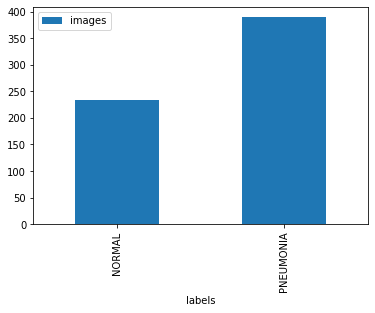

In [5]:
test_df.groupby(['labels']).count().plot.bar()

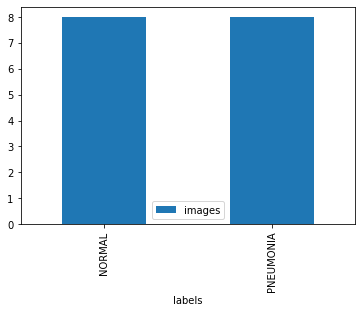

In [6]:
val_df.groupby(['labels']).count().plot.bar()

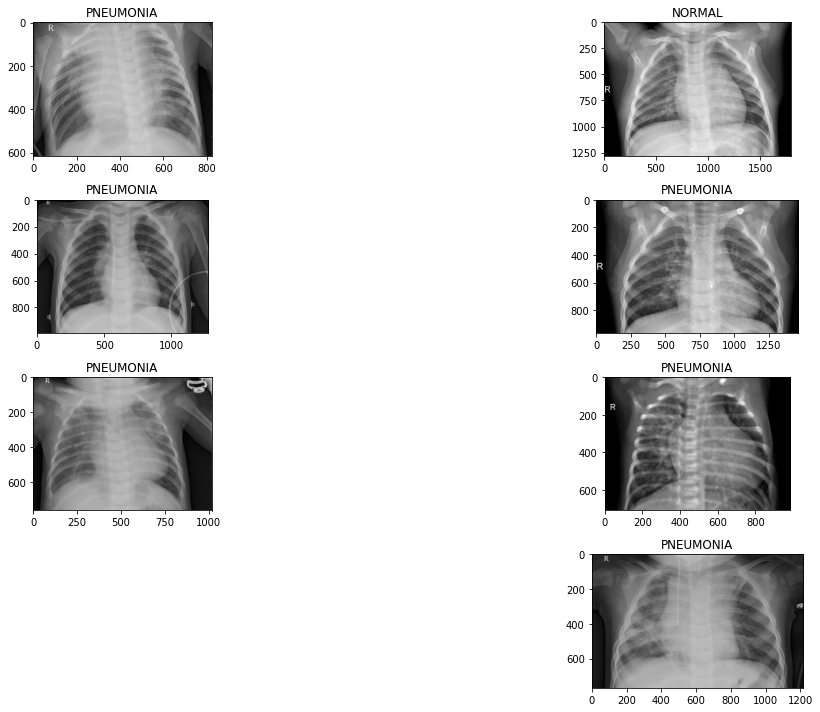

In [7]:
import PIL
import cv2
# Adjust the size of your images
plt.figure(figsize=(20,10))
count = 0
for iterator, row in (train_df.iterrows()):
  filename = row.images
  image = cv2.imread(filename)
  count +=1
  if count>8:break 
  plt.subplot(4,2,count)
  plt.title(row.labels)
  plt.imshow(image, cmap=plt.cm.bone)
  plt.tight_layout()


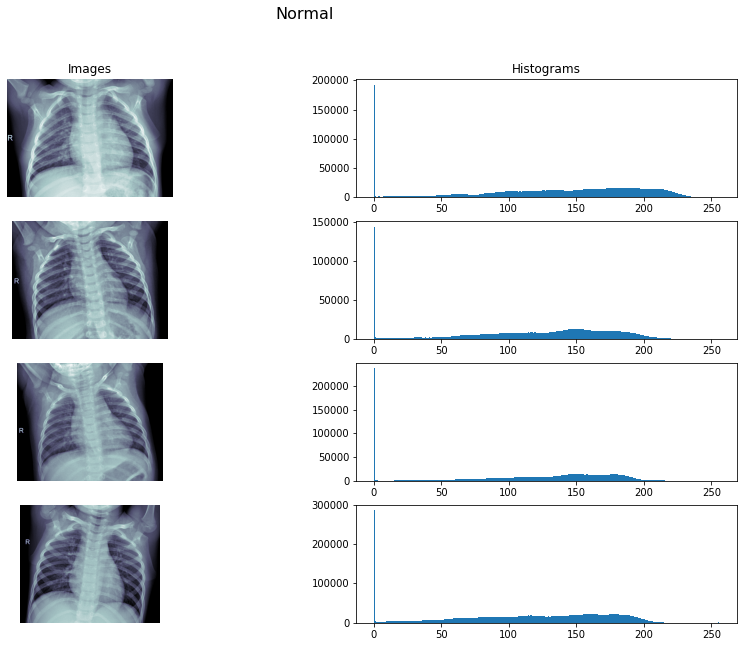

In [8]:
fig, ax = plt.subplots(4, 2, figsize=(15, 10))

count = 0 
for iterator, row in (train_df.iterrows()):
    if row.labels == 'NORMAL':
      filename = row.images
      image = plt.imread(filename)
      if count>=4: break
      ax[count, 0].imshow(image, cmap=plt.cm.bone)
      ax[count, 1].hist(image.ravel(), 256, [0,256])
      ax[count, 0].axis('off')
      if count == 0:
        ax[count, 0].set_title('Images')
        ax[count, 1].set_title('Histograms')
      count +=1
fig.suptitle('Normal', size=16)
plt.show()

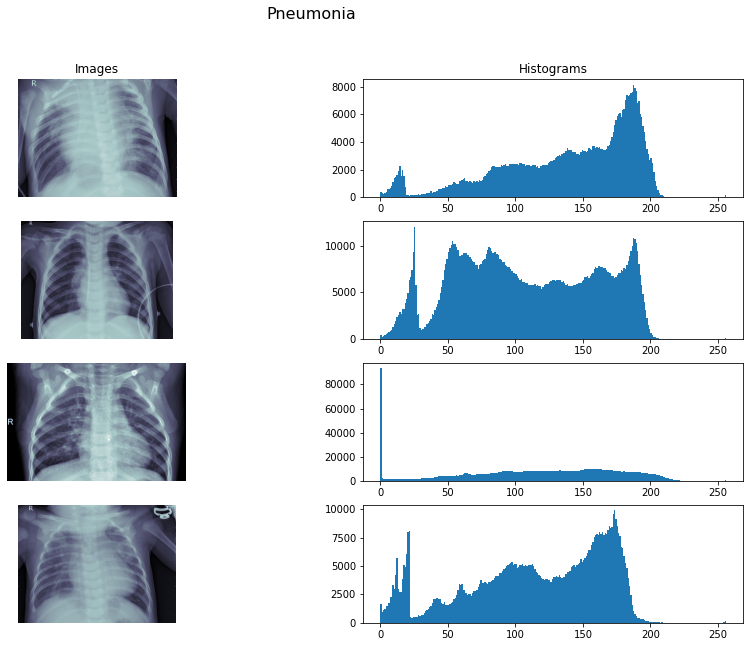

In [9]:
fig, ax = plt.subplots(4, 2, figsize=(15, 10))

count = 0 
for iterator, row in (train_df.iterrows()):
    if row.labels == 'PNEUMONIA':
      filename = row.images
      image = plt.imread(filename)
      if count>=4: break
      ax[count, 0].imshow(image, cmap=plt.cm.bone)
      ax[count, 1].hist(image.ravel(), 256, [0,256])
      ax[count, 0].axis('off')
      if count == 0:
        ax[count, 0].set_title('Images')
        ax[count, 1].set_title('Histograms')
      count +=1
fig.suptitle('Pneumonia', size=16)
plt.show()

In [10]:
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.preprocessing import image

## Standardization
The image_generator you created above will act to adjust your image data such that the new mean of the data will be zero, and the standard deviation of the data will be 1.

In other words, the generator will replace each pixel value in the image with a new value calculated by subtracting the mean and dividing by the standard deviation.

xi−μσ
 
Run the next cell to pre-process your data using the image_generator. In this step you will also be reducing the image size down to 320x320 pixel

In [11]:
def get_train_generator(Train_dir,val_dir,test_dir,target_w = 128, target_h = 128):      
    
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(rescale=1.0/255.0,
                                         rotation_range=15,
                                        samplewise_center=True,
                                        validation_split=0.30,
                                         fill_mode='nearest',
                                      samplewise_std_normalization= True)
    
    train_generator = image_generator.flow_from_directory(Train_dir,
                                                  shuffle=True,                                                  
                                                  class_mode='binary',
                                              target_size=(target_w, target_h))


    validation_datagen = ImageDataGenerator(rescale=1.0/255.0,
        samplewise_center=True,
        validation_split=0.30,
        samplewise_std_normalization= True)
    validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                    class_mode='binary',
                                                    shuffle=True,
                                              target_size=(target_w, target_h))
    
    test_datagen = ImageDataGenerator(rescale=1.0/255.0,
        samplewise_center=True,
        validation_split=0.30,
        samplewise_std_normalization= True)
    
    test_generator= test_datagen.flow_from_directory(test_dir,
                                                    class_mode='binary',
                                                    shuffle=True,
                                              target_size=(target_w, target_h))
    
   
    return train_generator ,validation_generator ,test_generator

In [12]:
target_w = 128
target_h = 128
train_generator,valid_generator,test_generator = get_train_generator(Train_path,Val_path,Test_path, target_w = target_w, target_h = target_h)

getting train generator...
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 128 pixels width and 128 pixels height
The maximum pixel value is 3.9908 and the minimum is -3.5968
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


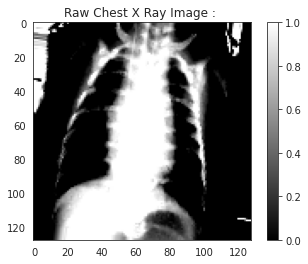

In [13]:
# Plot a processed image
sns.set_style("white")
generated_image, label = train_generator.__getitem__(0)
image = generated_image[0].reshape(target_w,target_h,3)

plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image : ')
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

Text(0, 0.5, '# Pixel')

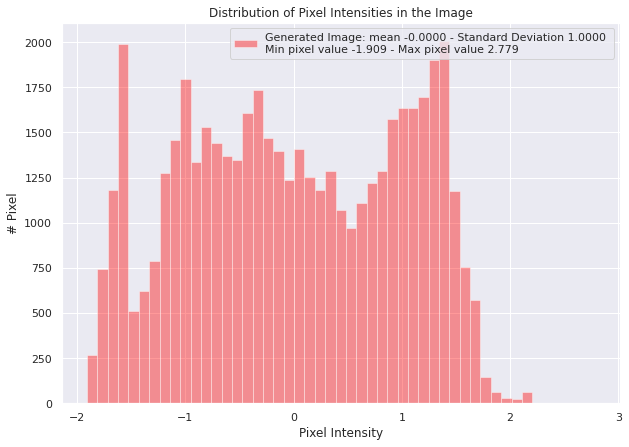

In [14]:
# Include a histogram of the distribution of the pixels
sns.set()
plt.figure(figsize=(10, 7))

# Plot histogram for generated image
sns.distplot(generated_image[0].ravel(), 
             label=f'Generated Image: mean {np.mean(generated_image[0]):.4f} - Standard Deviation {np.std(generated_image[0]):.4f} \n'
             f'Min pixel value {np.min(generated_image[0]):.4} - Max pixel value {np.max(generated_image[0]):.4}', 
             color='red', 
             kde=False)

# Place legends
plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')

In [15]:
neg, pos = np.bincount(train_generator.labels)
total = neg+pos
neg_freq = neg/(neg+pos)
pos_freq = pos/(neg+pos)
print(neg_freq)
print(pos_freq)


0.2570935582822086
0.7429064417177914


In [16]:
from sklearn.utils import class_weight
classweights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_generator.labels),
                                                 train_generator.labels)
print(classweights)


classweight = {0: classweights[0], 1: classweights[1]}

print('Weight for class 0: {:.2f}'.format(classweights[0]))
print('Weight for class 1: {:.2f}'.format(classweights[1]))

[1.9448173  0.67303226]
Weight for class 0: 1.94
Weight for class 1: 0.67


In [61]:
import matplotlib.pyplot as plt 
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Conv2D,Flatten,AveragePooling2D,Dropout
from tensorflow.keras import Model
print(tf.__version__)
# create the base pre-trained model
base_model = InceptionV3(include_top=False,weights='imagenet',input_shape=(128,128,3))
head_Model = base_model.output
head_Model = GlobalAveragePooling2D()(head_Model)
head_Model = Flatten(name="flatten")(head_Model)
head_Model = Dense(64, activation="relu")(head_Model)
head_Model = Dropout(0.5)(head_Model)
prediction = Dense(2, activation="softmax")(head_Model)

for layer in base_model.layers[:100]:
    layer.trainable = False


#Compose the final model
model = Model(inputs=base_model.input, outputs=prediction)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
gc.collect()
model.summary()

2.3.0
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_846 (Conv2D)             (None, 63, 63, 32)   864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_846 (BatchN (None, 63, 63, 32)   96          conv2d_846[0][0]                 
__________________________________________________________________________________________________
activation_846 (Activation)     (None, 63, 63, 32)   0           batch_normalization_846[0][0]    
_________________________________________________________________________________

In [22]:
from tensorflow.keras import callbacks

from tensorflow.keras.callbacks import ModelCheckpoint
EPOCHS = 50
BATCH_SIZE = 2048

Model_name = 'Inception_V3'+'_pretrained_model.h5'
checkpoint = ModelCheckpoint(Model_name, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [23]:
history = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[early_stopping,checkpoint],
    # The class weights go here
    class_weight=classweight) 

Epoch 1/50
163/163 [==============================] - ETA: 0s - loss: 0.7175 - accuracy: 0.4956
Epoch 00001: val_accuracy improved from -inf to 0.50160, saving model to Inception_V3_pretrained_model.h5
163/163 [==============================] - 84s 517ms/step - loss: 0.7175 - accuracy: 0.4956 - val_loss: 0.6940 - val_accuracy: 0.5016
Epoch 2/50
163/163 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.4879
Epoch 00002: val_accuracy did not improve from 0.50160
163/163 [==============================] - 83s 508ms/step - loss: 0.6936 - accuracy: 0.4879 - val_loss: 0.6934 - val_accuracy: 0.4808
Epoch 3/50
163/163 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5232
Epoch 00003: val_accuracy did not improve from 0.50160
163/163 [==============================] - 82s 505ms/step - loss: 0.6933 - accuracy: 0.5232 - val_loss: 0.6937 - val_accuracy: 0.4792
Epoch 4/50
163/163 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.550

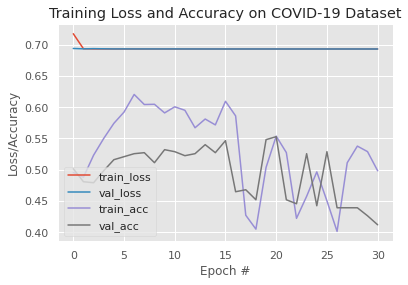

In [26]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------

# plot the training loss and accuracy
N = len(history.history['accuracy'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


In [27]:
# from tensorflow import keras
# model = keras.models.load_model

# model=  keras.models.load_model('/content/Densenet121_pretrained_model.h5')

predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))


Instructions for updating:
Please use Model.predict, which supports generators.


In [28]:
y_pred  = [np.argmax(proab) for proab in predicted_vals]
y_test = test_generator.labels

## ROC Curve and AUROC
We'll cover topic of model evaluation in much more detail in later weeks, but for now we'll walk through computing a metric called the AUC (Area Under the Curve) from the ROC (Receiver Operating Characteristic) curve. This is also referred to as the AUROC value, but you will see all three terms in reference to the technique, and often used almost interchangeably.

For now, what you need to know in order to interpret the plot is that a curve that is more to the left and the top has more "area" under it, and indicates that the model is performing better.

We will use the util.get_roc_curve() function which has been provided for you in util.py. Look through this function and note the use of the sklearn library functions to generate the ROC curves and AUROC values for our model.

roc_curve
roc_auc_score

In [29]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import itertools
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.55      0.46       234
           1       0.64      0.49      0.56       390

    accuracy                           0.51       624
   macro avg       0.52      0.52      0.51       624
weighted avg       0.55      0.51      0.52       624



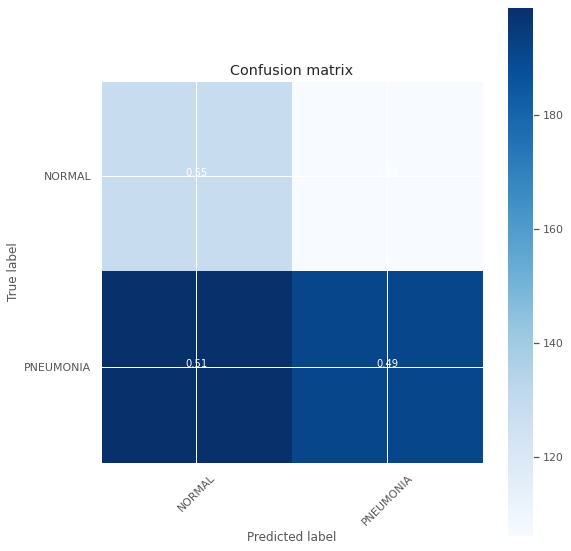

In [30]:
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

cnf_matrix = confusion_matrix(y_test,y_pred)
fig = plot_confusion_matrix(cnf_matrix,class_names=['NORMAL','PNEUMONIA'])

We can phrase this easily in terms of true positives, true negatives, false positives, and false negatives: 

$$sensitivity = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

$$specificity = \frac{\text{true negatives}}{\text{true negatives} + \text{false positives}}$$

Let's calculate sensitivity and specificity for our model:

In [31]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
Senstivity  = tp/(tp+fn)
Specificity = tn/(tn+fp)

print("Senstivity = ",Senstivity)
print ("Specificity = ",Specificity)



Senstivity =  0.4897435897435897
Specificity =  0.5470085470085471


In [50]:
import random
from google.colab.patches import cv2_imshow 
from tensorflow.keras.preprocessing import image
class_names=['NORMAL','PNEUMONIA']

ORIGINAL = val_imgs[random.randint(0,len(val_imgs)-1)]
original = cv2.imread(ORIGINAL)
orig = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
print("Image: ",ORIGINAL)
print("Shape of image :",original.shape)
print(orig.shape)

DIM = 128
img = image.load_img(ORIGINAL, target_size=(DIM, DIM))
x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(x.shape)

# Preict with the model 
idx = np.argmax(model.predict(x))
print("Predicted label ",class_names[idx])

Image:  /content/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
Shape of image : (656, 1016, 3)
(656, 1016, 3)
(1, 128, 128, 3)
Predicted label  NORMAL


## Explainability Using GradCAM

Refernce : https://towardsdatascience.com/explainability-and-visibility-in-covid-19-x-ray-classifiers-with-deep-learning-c12c3247f905

In [51]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        # resize the heatmap to oringnal X-Ray image size
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

In [52]:

cam = GradCAM(model=model, classIdx=idx, layerName='mixed9_1') # find the last 4d shape "mixed10" in this case
heatmap = cam.compute_heatmap(x)

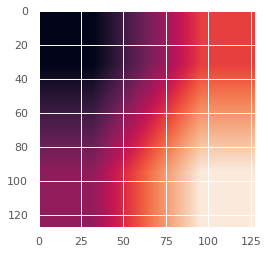

In [53]:
#show the calculated heatmap
plt.imshow(heatmap)
plt.show()

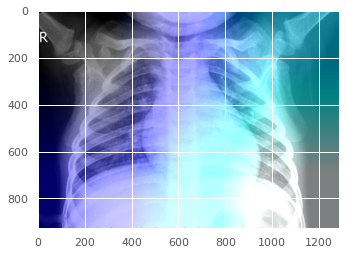

In [47]:
# Old fashioned way to overlay a transparent heatmap onto original image, the same as above
INTENSITY = 0.5
heatmapY = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
heatmapY = cv2.applyColorMap(heatmapY, cv2.COLORMAP_HOT) 
imageY = cv2.addWeighted(heatmapY, 0.5, orig, 1.0, 0)
plt.imshow(imageY)

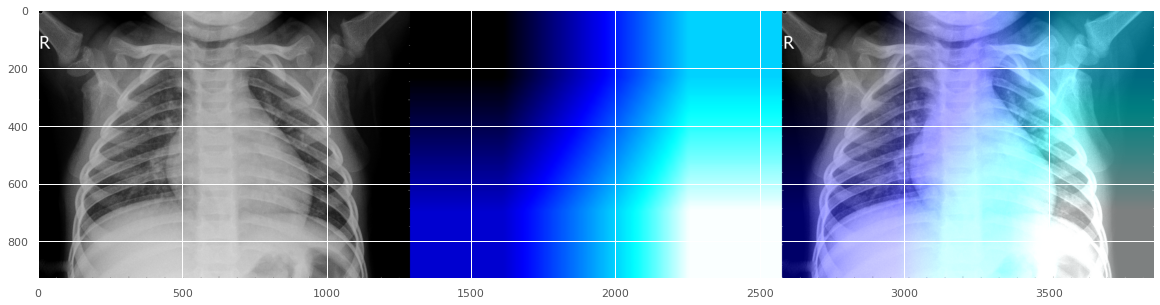

In [48]:
# draw the orignal x-ray, the heatmap, and the overlay together
output = np.hstack([orig, heatmapY, imageY])
fig, ax = plt.subplots(figsize=(20, 18))
ax.imshow(np.random.rand(1, 99), interpolation='nearest')
plt.imshow(output)
plt.show()